# TensorFlow 那些事儿之DL中的 HELLO WORLD


- 基于MNIST数据集，运用TensorFlow中 **tf.estimator** 预制的 **tf.estimator.DNNClassifier** 搭建一个简单的多层神经网络，实现模型的训练，验证和测试

- TensorBoard的简单使用


## 看看MNIST数据长什么样子的

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

### 导入各个库

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing


from tensorflow import data
from tensorflow.python.feature_column import feature_column

tf.__version__

'1.8.0'

### MNIST数据集导入
- MNIST数据集包含70000张图像和对应的标签（图像的分类）。数据集被划为3个子集：训练集，验证集和测试集。

- 定义数据集和模型相关的基本参数

In [2]:
TRAIN_DATA_FILES_PATTERN = 'data_csv/mnist_train.csv'
VAL_DATA_FILES_PATTERN = 'data_csv/mnist_val.csv'
TEST_DATA_FILES_PATTERN = 'data_csv/mnist_test.csv'

MULTI_THREADING = True
RESUME_TRAINING = False

NUM_CLASS = 10
IMG_SHAPE = [28,28]

IMG_WIDTH = 28
IMG_HEIGHT = 28
BATCH_SIZE = 128

In [3]:
# train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN)
# train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN, header=None, names=HEADER )
train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN, header=None)
test_data = pd.read_csv(TEST_DATA_FILES_PATTERN, header=None)
val_data = pd.read_csv(VAL_DATA_FILES_PATTERN, header=None)

train_values = train_data.values
train_data = train_values[:,1:]
train_label = train_values[:,0:1]

val_values = val_data.values
val_data = val_values[:,1:]
val_label = val_values[:,0:1]

test_values = test_data.values
test_data = test_values[:,1:]
test_label = test_values[:,0:1]

print('test_data',np.shape(test_data))
print('test_label',np.shape(test_label))

print('val_data',np.shape(val_data))
print('val_label',np.shape(val_label))

print('train_data',np.shape(train_data))
print('train_label',np.shape(train_label))

# train_data.head(10)
# test_data.head(10)

test_data (10000, 784)
test_label (10000, 1)
val_data (5000, 784)
val_label (5000, 1)
train_data (55000, 784)
train_label (55000, 1)


### 用来绘制图片的辅助函数

In [6]:
img_shape = IMG_SHAPE

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 直观画出来看看

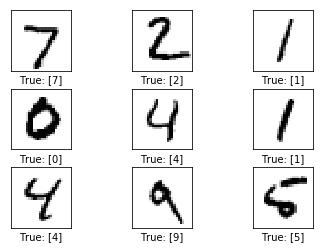

In [7]:
# Get the first images from the test-set.
images = test_data[0:9]

# Get the true classes for those images.
cls_true = test_label[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

##  重头戏之怎么用 tf.estimator.DNNClassifier 

- [官网API解释](https://tensorflow.google.cn/api_docs/python/tf/estimator/DNNClassifier)

- 看看都有哪些参数

```python
__init__(
    hidden_units,
    feature_columns,
    model_dir=None,
    n_classes=2,
    weight_column=None,
    label_vocabulary=None,
    optimizer='Adagrad',
    activation_fn=tf.nn.relu,
    dropout=None,
    input_layer_partitioner=None,
    config=None,
    warm_start_from=None,
    loss_reduction=losses.Reduction.SUM,
    batch_norm=False
)
```
- 本例中，主要用了 **tf.estimator.DNNClassifier** 中的 `hidden_units`,`feature_columns`,`model_dir`,`activation_fn`,`n_classes`

### 先看看input_fn之创建输入函数

```python
tf.estimator.inputs.numpy_input_fn(
    x,
    y=None,
    batch_size=128,
    num_epochs=1,
    shuffle=None,
    queue_capacity=1000,
    num_threads=1
)
```

Returns input function that would feed dict of numpy arrays into the model.

In [8]:
batch_size = BATCH_SIZE
# Define the input function for training
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images': np.array(train_data)},
    y = np.array(train_label),
    batch_size=batch_size,
    num_epochs=None, 
    shuffle=True)

In [16]:
# Evaluate the Model
# Define the input function for evaluating
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images': np.array(test_data)},
    y = np.array(test_label),
    batch_size=batch_size, 
    shuffle=False)

In [10]:
# Predict some images
some_images = test_data[0:9]
print('some images',np.shape(some_images))

# Define the input function for predicting
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': some_images},
    num_epochs=1,
    shuffle=False)

some images (9, 784)


### 主要是feature_columns比较头疼


- [官网关于featrue_columns的教程](https://tensorflow.google.cn/get_started/feature_columns?hl=zh-cn)


- 可以将 **特征列** 视为原始数据和 `Estimator` 之间的媒介。特征列内容丰富，使您可以将各种原始数据转换为`Estimator`可以使用的格式，从而可以轻松地进行实验。


- 如下图所示，可以通过 Estimator（鸢尾花的 `DNNClassifier`）的 `feature_columns` 参数指定模型的输入。特征列在输入数据（由 `input_fn` 返回）与模型之间架起了桥梁。

<img src="https://tensorflow.google.cn/images/feature_columns/inputs_to_model_bridge.jpg?hl=zh-cn" width = 80% height = 80% />


In [11]:
feature_x = tf.feature_column.numeric_column('images', shape=IMG_SHAPE)

feature_columns = [feature_x]

### 指定hidden_units构造DNN

本例中构造3个隐藏层的DNN，分别有512，256，128神经元。

In [12]:
num_hidden_units = [512, 256, 128]

### 呼之欲出的model之DNNClassifier

In [13]:
num_classes = NUM_CLASS
model_name = 'simple_dnn'

model = tf.estimator.DNNClassifier(feature_columns = feature_columns,
                                   hidden_units = num_hidden_units,
                                   activation_fn = tf.nn.relu,
                                   n_classes = num_classes,
                                   model_dir = model_name)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_evaluation_master': '', '_num_ps_replicas': 0, '_task_type': 'worker', '_task_id': 0, '_service': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_session_config': None, '_train_distribute': None, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'simple_dnn', '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x104890e10>, '_save_checkpoints_steps': None, '_is_chief': True, '_global_id_in_cluster': 0}


### 来呀，训练起来

In [14]:
# Train the Model
model.train(train_input_fn, steps = 2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into simple_dnn/model.ckpt.
INFO:tensorflow:loss = 12202.948, step = 1
INFO:tensorflow:global_step/sec: 57.1947
INFO:tensorflow:loss = 151.63995, step = 101 (1.750 sec)
INFO:tensorflow:global_step/sec: 67.3086
INFO:tensorflow:loss = 89.586075, step = 201 (1.487 sec)
INFO:tensorflow:global_step/sec: 75.5622
INFO:tensorflow:loss = 86.228546, step = 301 (1.329 sec)
INFO:tensorflow:global_step/sec: 73.6666
INFO:tensorflow:loss = 46.27453, step = 401 (1.350 sec)
INFO:tensorflow:global_step/sec: 86.8864
INFO:tensorflow:loss = 65.17306, step = 501 (1.151 sec)
INFO:tensorflow:global_step/sec: 78.4508
INFO:tensorflow:loss = 39.935963, step = 601 (1.276 sec)
INFO:tensorflow:global_step/sec: 76.414
INFO:tensorflow:loss = 43

### 验证一下瞅瞅

In [17]:
# Use the Estimator 'evaluate' method
model.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-25-02:57:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from simple_dnn/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-25-02:57:43
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9231, average_loss = 0.26094428, global_step = 2000, loss = 33.03092


{'accuracy': 0.9231,
 'average_loss': 0.26094428,
 'global_step': 2000,
 'loss': 33.03092}

### 测试一下看看

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from simple_dnn/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
PRED [{'classes': array([b'7'], dtype=object), 'probabilities': array([3.1019855e-08, 7.5660289e-05, 4.3719533e-04, 1.0263568e-03,
       3.7715839e-10, 3.7429190e-06, 1.8247435e-11, 9.9843413e-01,
       2.9076916e-06, 2.0014246e-05], dtype=float32), 'logits': array([-1.5060661,  6.293315 ,  8.0474415,  8.900832 , -5.9157834,
        3.2869267, -8.944426 , 15.781005 ,  3.0344212,  4.9635053],
      dtype=float32), 'class_ids': array([7])}, {'classes': array([b'2'], dtype=object), 'probabilities': array([9.3555311e-12, 1.7783657e-05, 9.9992037e-01, 2.8249107e-05,
       5.3530413e-10, 2.7140834e-06, 1.6186158e-08, 3.0481626e-05,
       3.8288712e-07, 2.6961356e-12], dtype=float32), 'logits': array([-4.1641617 , 10.293661  , 21.2

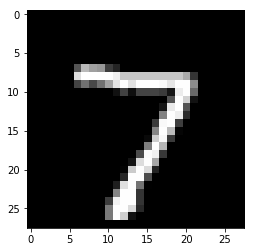

Model prediction: {'classes': array([b'7'], dtype=object), 'probabilities': array([3.1019855e-08, 7.5660289e-05, 4.3719533e-04, 1.0263568e-03,
       3.7715839e-10, 3.7429190e-06, 1.8247435e-11, 9.9843413e-01,
       2.9076916e-06, 2.0014246e-05], dtype=float32), 'logits': array([-1.5060661,  6.293315 ,  8.0474415,  8.900832 , -5.9157834,
        3.2869267, -8.944426 , 15.781005 ,  3.0344212,  4.9635053],
      dtype=float32), 'class_ids': array([7])}


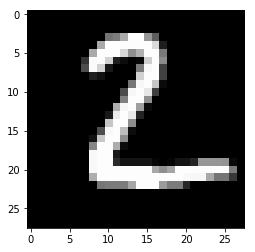

Model prediction: {'classes': array([b'2'], dtype=object), 'probabilities': array([9.3555311e-12, 1.7783657e-05, 9.9992037e-01, 2.8249107e-05,
       5.3530413e-10, 2.7140834e-06, 1.6186158e-08, 3.0481626e-05,
       3.8288712e-07, 2.6961356e-12], dtype=float32), 'logits': array([-4.1641617 , 10.293661  , 21.230812  , 10.756443  , -0.11729379,
        8.413836  ,  3.2917824 , 10.832505  ,  6.4553657 , -5.40831   ],
      dtype=float32), 'class_ids': array([2])}


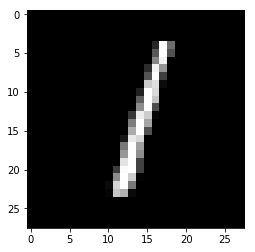

Model prediction: {'classes': array([b'1'], dtype=object), 'probabilities': array([3.7955402e-08, 9.9978930e-01, 5.5184877e-08, 9.5722805e-07,
       2.1806601e-08, 2.2916425e-05, 4.4052288e-07, 5.2652357e-08,
       1.8516273e-04, 1.0916790e-06], dtype=float32), 'logits': array([ 4.251214 , 21.337858 ,  4.6254926,  7.4788446,  3.6970162,
       10.654412 ,  6.7027655,  4.578514 , 12.7437935,  7.6102757],
      dtype=float32), 'class_ids': array([1])}


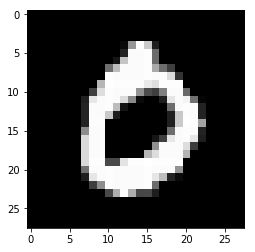

Model prediction: {'classes': array([b'0'], dtype=object), 'probabilities': array([9.9994290e-01, 6.9117243e-13, 5.2136038e-05, 5.1440813e-10,
       4.1425032e-09, 1.6684993e-08, 5.4172278e-07, 3.7449974e-12,
       1.4335598e-08, 4.4057947e-06], dtype=float32), 'logits': array([28.58466  ,  0.5843297, 18.723063 ,  7.196712 ,  9.282751 ,
       10.675961 , 14.156205 ,  2.2741158, 10.524197 , 16.252127 ],
      dtype=float32), 'class_ids': array([0])}


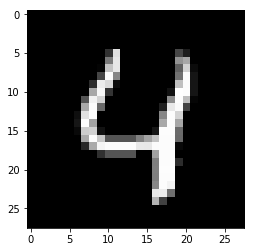

Model prediction: {'classes': array([b'4'], dtype=object), 'probabilities': array([1.0917678e-07, 4.6880842e-07, 3.1331413e-06, 1.5151719e-06,
       9.9866843e-01, 3.3861430e-05, 4.1402629e-07, 3.1395061e-06,
       8.3070904e-07, 1.2881418e-03], dtype=float32), 'logits': array([ 4.783898 ,  6.241123 ,  8.14072  ,  7.4142137, 20.812862 ,
       10.520961 ,  6.1168585,  8.14275  ,  6.8132086, 14.15964  ],
      dtype=float32), 'class_ids': array([4])}


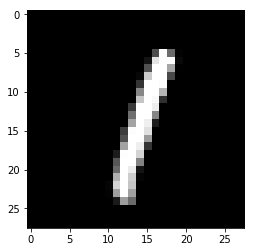

Model prediction: {'classes': array([b'1'], dtype=object), 'probabilities': array([1.4053359e-07, 9.9649209e-01, 5.8620419e-05, 3.8160681e-05,
       2.3504621e-05, 8.9442939e-05, 1.4636164e-07, 2.8416137e-03,
       4.4529152e-04, 1.0984669e-05], dtype=float32), 'logits': array([-1.1078992, 14.666406 ,  4.925493 ,  4.496215 ,  4.011606 ,
        5.34801  , -1.0672659,  8.806537 ,  6.9531384,  3.2509098],
      dtype=float32), 'class_ids': array([1])}


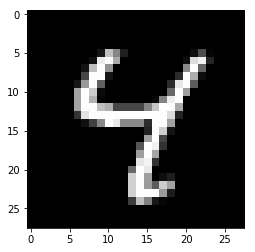

Model prediction: {'classes': array([b'4'], dtype=object), 'probabilities': array([2.5710714e-04, 1.8235329e-04, 1.5350768e-03, 2.4388819e-04,
       9.0745831e-01, 3.0532987e-03, 1.0158311e-03, 7.2779250e-04,
       3.7224952e-02, 4.8301376e-02], dtype=float32), 'logits': array([ 3.486335 ,  3.1427875,  5.2731776,  3.4335523, 11.655245 ,
        5.9608197,  4.8603044,  4.526858 ,  8.461576 ,  8.722057 ],
      dtype=float32), 'class_ids': array([4])}


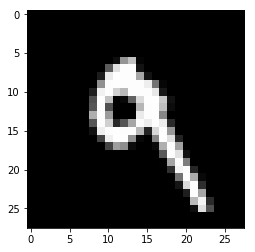

Model prediction: {'classes': array([b'9'], dtype=object), 'probabilities': array([3.0740997e-05, 4.3380854e-04, 2.1834906e-04, 1.7432487e-03,
       7.2680235e-02, 2.1356733e-03, 1.2263356e-05, 9.6945018e-02,
       6.2047616e-03, 8.1959587e-01], dtype=float32), 'logits': array([-1.2783484 ,  1.368657  ,  0.68214905,  2.7595596 ,  6.4898787 ,
        2.9625912 , -2.1973302 ,  6.777953  ,  4.029126  ,  8.912621  ],
      dtype=float32), 'class_ids': array([9])}


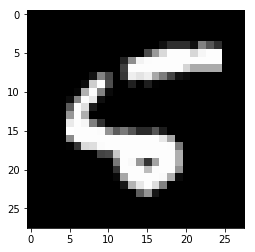

Model prediction: {'classes': array([b'4'], dtype=object), 'probabilities': array([1.5645884e-02, 6.6961297e-03, 2.3678295e-02, 3.0475596e-04,
       4.4073054e-01, 2.6076658e-02, 4.2976376e-02, 2.7712289e-04,
       7.9354346e-02, 3.6425990e-01], dtype=float32), 'logits': array([4.988461 , 4.139783 , 5.402812 , 1.0500094, 8.326687 , 5.499294 ,
       5.9989038, 0.9549589, 6.6121764, 8.136121 ], dtype=float32), 'class_ids': array([4])}


In [18]:
# Use the model to predict the images class
preds = list(model.predict(test_input_fn))
print('PRED',preds)

n_images = 9
# Display
for i in range(n_images):
    plt.imshow(np.reshape(some_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])